# <center>Assignment 2 LSTM - No Window Size

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [12]:
# Basic Time Series Setting
import statsmodels.api as smapi
import statsmodels.tsa.api as smt

In [104]:
# RNN Package Setting
import time
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

## 1. Exploratory Data Analysis

In [35]:
data=pd.read_csv('internet_retail_sales.csv',parse_dates=[0], index_col=0)
sales=data.values

In [3]:
data.head(10)

,Sales
Dates,
2006-11-01,155.7
2006-12-01,167.9
2007-01-01,126.0
2007-02-01,132.7
2007-03-01,144.2
2007-04-01,147.0
2007-05-01,154.9
2007-06-01,159.3
2007-07-01,167.3


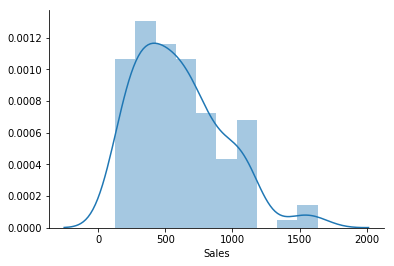

In [5]:
sns.distplot(sales,hist=True,label='sales')
sns.despine()
plt.show()

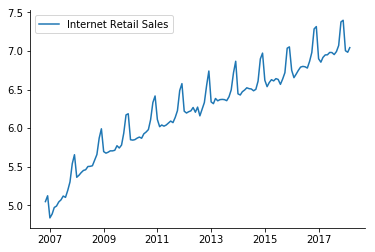

In [286]:
plt.plot(np.log(data),label='Internet Retail Sales')
plt.legend()
sns.despine()
plt.show()

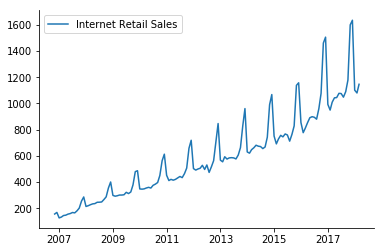

In [287]:
plt.plot(data,label='Internet Retail Sales')
plt.legend()
sns.despine()
plt.show()

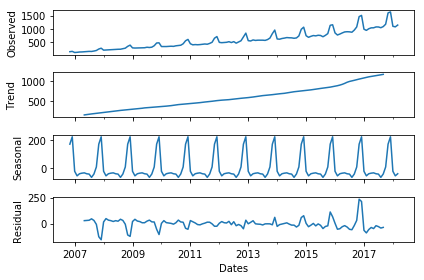

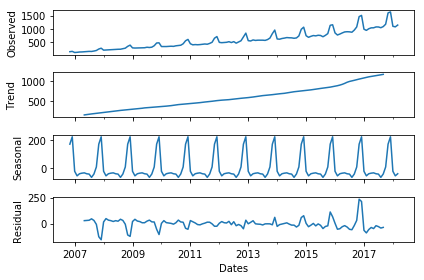

In [16]:
decomp_obj = smapi.tsa.seasonal_decompose(data['Sales'])
decomp_obj.plot()

## 2. Data Preparation

In [7]:
np.random.seed(1)

### Prepare X and Y

In [99]:
# Prepare X and Y
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df = df.drop(0)
    return df

data_supervised=timeseries_to_supervised(sales, 1)
print(data_supervised.head(10))
data_supervised_values=data_supervised.values
# data_supervised_values

        0      0
1   155.7  167.9
2   167.9  126.0
3   126.0  132.7
4   132.7  144.2
5   144.2  147.0
6   147.0  154.9
7   154.9  159.3
8   159.3  167.3
9   167.3  164.5
10  164.5  180.3


### Train Test Split

In [145]:
# train test split
test_size=12
train, test=data_supervised_values[0:-test_size], data_supervised_values[-test_size:]

### Standardisation

In [146]:
# fit scaler
scaler = StandardScaler()
scaler = scaler.fit(train)
# transform train
train = train.reshape(train.shape[0], train.shape[1])
train_scaled = scaler.transform(train)
# transform test
test = test.reshape(test.shape[0], test.shape[1])
test_scaled = scaler.transform(test)
print(train_scaled[1:10])
print('\n')
print(test_scaled[1:10])

[[-1.34338228 -1.51412662]
 [-1.49453377 -1.49004008]
 [-1.47036396 -1.44869751]
 [-1.42887847 -1.43863149]
 [-1.41877765 -1.41023095]
 [-1.39027892 -1.39441292]
 [-1.37440621 -1.36565287]
 [-1.34554674 -1.37571889]
 [-1.35564756 -1.3189178 ]]


[[1.81240108 1.78716732]
 [1.81817297 1.90364551]
 [1.93505384 1.8986125 ]
 [1.93000343 1.79939034]
 [1.83043825 1.95002108]
 [1.98158974 2.26781961]
 [2.30048692 3.7813171 ]
 [3.81921668 3.90929931]
 [3.94764133 1.99100415]]


In [217]:
y_train_raw=train[:,-1]
y_test_raw=test[:,-1]
y_train_raw=y_train_raw.reshape(y_train_raw.shape[0],1)
y_test_raw=y_test_raw.reshape(y_test_raw.shape[0],1)

In [180]:
scaler_y=StandardScaler()
scaler_y.fit(y_train_raw)

StandardScaler(copy=True, with_mean=True, with_std=True)

### Reshpe Data Window into 3D

In [148]:
X_train, y_train=train_scaled[:,0:-1], train_scaled[:,-1]
X_test,y_test=test_scaled[:,0:-1], test_scaled[:,-1]
X_train=X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test=X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print(X_train.shape)
print(X_test.shape)

(124, 1, 1)
(12, 1, 1)


## 3. RNN-LSTM Model Fitting

In [277]:
# build LSTM Model
epochs=10
neurons=30
model=Sequential()
model.add(LSTM(100,batch_input_shape=(1, X_train.shape[1], X_train.shape[2]),stateful=True))
model.add(Dropout(0.2))
model.add(Dense(1))

# compile model for use
start=time.time()
model.compile(loss="mse", optimizer="rmsprop")
print("Compilation Time : ", time.time() - start)

Compilation Time :  0.005983829498291016


In [278]:
max_len = 1
from keras.callbacks import Callback  
class ResetStatesCallback(Callback):
    def __init__(self):
        self.counter = 0

    def on_batch_begin(self, batch, logs={}):
        if self.counter % max_len == 0:
            self.model.reset_states()
        self.counter += 1

In [279]:
# Training Model
history=model.fit(X_train,y_train,callbacks=[ResetStatesCallback()],batch_size=1,nb_epoch=10,shuffle=False)
# validation_split=0.1,
# model.reset_states()

Epoch 1/10
124/124 [==============================] - 186s 2s/step - loss: 0.6467
Epoch 2/10
124/124 [==============================] - 183s 1s/step - loss: 0.2853
Epoch 3/10
124/124 [==============================] - 183s 1s/step - loss: 0.1609
Epoch 4/10
124/124 [==============================] - 182s 1s/step - loss: 0.1281
Epoch 5/10
124/124 [==============================] - 182s 1s/step - loss: 0.1251
Epoch 6/10
124/124 [==============================] - 186s 1s/step - loss: 0.1367
Epoch 7/10
124/124 [==============================] - 193s 2s/step - loss: 0.1280
Epoch 8/10
124/124 [==============================] - 198s 2s/step - loss: 0.1241
Epoch 9/10
124/124 [==============================] - 185s 1s/step - loss: 0.1288
Epoch 10/10
124/124 [==============================] - 200s 2s/step - loss: 0.1331


In [280]:
# One-step Predict
train_predict=model.predict(X_train,batch_size=1)
test_predict=model.predict(X_test,batch_size=1)

# Inverse Train Test Prediction
train_predict=scaler_y.inverse_transform(train_predict)
test_predict=scaler_y.inverse_transform(test_predict)

### Train Score

In [238]:
# epochs_summary=[]
# rmse=[]
# neurons_summary=[]

In [281]:
train_score=math.sqrt(mean_squared_error(y_test_raw,test_predict))
train_score
rmse.append(train_score)
epochs_summary.append(epochs)
neurons_summary.append(neurons)

In [282]:
print(rmse)
print(epochs_summary)
print(neurons_summary)

[275.72354314991827, 245.6900679886731, 262.98524009613766, 262.98524009613766, 254.7064931583713, 220.08416636999164, 938.5967834751999]
[[10], 10, 10, 10, 10, 10, 10]
[[10], 10, 20, 20, 20, 100, 30]


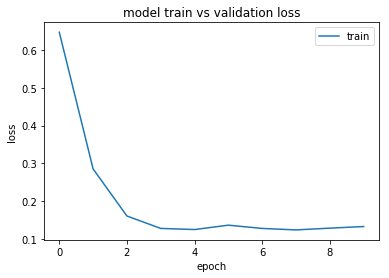

In [284]:
fig=plt.figure()
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
fig.savefig('fig1.png')

In [240]:
# epochs_summary.append(10)
# neurons_summary.append(10)

In [269]:
print(epochs_summary)
print(neurons_summary)
print(rmse)

[[10], 10, 10, 10, 10, 10]
[[10], 10, 20, 20, 20, 100]
[275.72354314991827, 245.6900679886731, 262.98524009613766, 262.98524009613766, 254.7064931583713, 220.08416636999164]


### Visualization

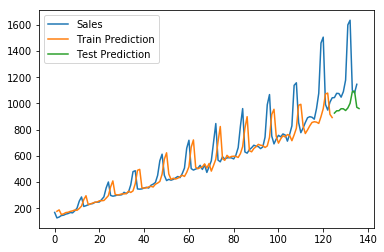

In [258]:
fig=plt.figure()
plt.plot(data.values[1:],label='Sales')
plt.plot(np.arange(1,len(train_predict)+1),train_predict,label='Train Prediction')
plt.plot(np.arange(len(train_predict)+1,len(train_predict)+test_size+1),test_predict,label='Test Prediction')
plt.legend()
plt.show()
fig.savefig('fig1.png')

In [216]:
len(test_predict)

12

In [206]:
len(train_predict)

124

In [207]:
len(data)

137

In [203]:
np.arange(1,len(train_predict)+1)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124])

In [210]:
np.arange(len(train_predict)+1,len(train_predict)+test_size+1)

array([125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136])